# Understanding the Situation

# 0.0 IMPORTS

## 0.1 Libraries

In [ ]:
#!pip install psycopg2

In [93]:
import random
import bisect
import warnings

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display         import Image
from IPython.core.display    import HTML

from imblearn                import combine        as c

from pandas_profiling        import ProfileReport

from sklearn.metrics         import (accuracy_score, roc_auc_score, average_precision_score, precision_score,
                                    recall_score, f1_score, cohen_kappa_score, balanced_accuracy_score, classification_report)
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold

from boruta                  import BorutaPy

from scikitplot.metrics      import plot_confusion_matrix


import sys
sys.path.append('../')
## My Functions
from modules.postgres import Postgres

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [16]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [17]:
jupyter_settings()

### 0.2.2 Functions

In [207]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m




def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))




def age_stage(num, breakpoints=[10, 20, 30, 45, 60, 70, 80, 120], result='01234567'):
    i = bisect.bisect(breakpoints, num-1)
    age_mapping = {
        0: 'Child',
        1: 'Teenager',
        2: 'Young',
        3: 'Adult',
        4: 'Midlife',
        5: 'Senior',
        6: 'Mature Adulthood',
        7: 'Late Adulthood'
    }
    return age_mapping[i]



def ml_scores(model_name, y, yhat, yhat_proba):
    precision = precision_score(y, yhat)
    recall = recall_score(y, yhat)
    f1 = f1_score(y, yhat)
    kappa = cohen_kappa_score(y, yhat)
    balanced_accuracy = balanced_accuracy_score(y, yhat)
    ap = average_precision_score(y, yhat_proba)
    roc_auc = roc_auc_score(y, yhat_proba)
    
    return pd.DataFrame({ 'Model Name': model_name, 
                       'Precision': precision, 
                       'Recall': recall,
                       'F1 Score': f1,
                       'Kappa': kappa,
                       'Balanced Accuracy': balanced_accuracy,
                       'Average Precision Score': ap,
                       'ROC AUC': roc_auc}, index=[0])
    

    
def cross_validation(X_train, y_train, model_name, model, num_folds=5, verbose=True):
    # k-fold generate
    num_folds = num_folds
    kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    precision_acc_list = []
    recall_acc_list = []
    f1_acc_list = []
    kappa_acc_list = []
    balanced_acc_list = []
    ap_acc_list = []
    roc_auc_acc_list = []

    i = 1
    for train_ix, val_ix in kfold.split(X_train, y_train):
        if verbose:
            print('Fold Number: {}/{}'.format(i, num_folds))
        # get fold
        X_train_fold = X_train.iloc[train_ix]
        y_train_fold = y_train.iloc[train_ix]

        X_val_fold = X_train.iloc[val_ix]
        y_val_fold = y_train.iloc[val_ix]

        # training model
        model.fit(X_train_fold, y_train_fold)

        # prediction
        yhat = model.predict(X_val_fold)
        yhat_proba = model.predict_proba(X_val_fold)[:,1]

        # metrics
        model_result = ml_scores(model_name, y_val_fold, yhat, yhat_proba)
        
        #Store Performance of each KFold iteration
        precision_acc_list.append(model_result['Precision'].tolist())
        recall_acc_list.append(model_result['Recall'].tolist())
        f1_acc_list.append(model_result['F1 Score'].tolist())
        kappa_acc_list.append(model_result['Kappa'].tolist())
        balanced_acc_list.append(model_result['Balanced Accuracy'].tolist())
        ap_acc_list.append(model_result['Average Precision Score'].tolist())
        roc_auc_acc_list.append(model_result['ROC AUC'].tolist())
        
        i += 1
        
    dict_result = {
                    'Model Name': [model_name],
                    'Precision CV': [np.round(np.mean(precision_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_acc_list),4).astype(str)],
                    'Recall CV': [np.round(np.mean(recall_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_acc_list),4).astype(str)],
                    'F1 Score CV': [np.round(np.mean(f1_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_acc_list),4).astype(str)],
                    'Kappa CV': [np.round(np.mean(kappa_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(kappa_acc_list),4).astype(str)],
                    'Balanced Accuracy': [np.round(np.mean(balanced_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(balanced_acc_list),4).astype(str)],
                    'Average Precision Score CV': [np.round(np.mean(ap_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(ap_acc_list),4).astype(str)],
                    'ROC AUC CV': [np.round(np.mean(roc_auc_acc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_auc_acc_list),4).astype(str)]
                }

    return pd.DataFrame(dict_result)

## 0.3 Loading data

In [19]:
# class instantiation
pg = Postgres()

# schemas and tables
schema = pg.inspect_schema()
schema

{'pa004': ['users', 'vehicle', 'insurance']}

In [21]:
# query table
dict_tables = pg.get_data()

### 0.3.1 Table Users

In [23]:
users = dict_tables['users']
users.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


### 0.3.2 Table Vehicle

In [24]:
vehicle = dict_tables['vehicle']
vehicle.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


### 0.3.3 Table Insurance

In [25]:
insurance = dict_tables['insurance']
insurance.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


### 0.3.4 Merge Dataset

In [29]:
df_raw = pd.merge(users, vehicle, how="inner", on="id")
df_raw = pd.merge(df_raw, insurance, how="inner", on="id")

In [30]:
df_raw.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

### 0.3.5 Saving Test Data

In [31]:
# Apply stratified sampling in order to keep target variable proportion in the train and test datasets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_raw, df_raw['response']):
    train_dataset = df_raw.loc[train_index].reset_index(drop=True)
    test_dataset = df_raw.loc[test_index].reset_index(drop=True)
    
# Convert to .Feather Data
train_dataset.to_feather('../00-Data/train_dataset.feather')
test_dataset.to_feather('../00-Data/test_dataset.feather')

### 0.3.6 Read Training Dataset

In [33]:
df_train = pd.read_feather('../00-Data/train_dataset.feather')

# 1.0 DATA DESCRIPTION

In [34]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,274711,Male,22,40.0,152.0,1,< 1 Year,Yes,0,25455.0,203,0
1,216540,Female,26,8.0,26.0,1,< 1 Year,No,1,38393.0,45,0
2,78984,Female,32,28.0,122.0,1,< 1 Year,Yes,0,32118.0,35,1
3,218369,Male,32,37.0,152.0,1,< 1 Year,Yes,0,37711.0,215,0
4,307216,Female,24,28.0,156.0,1,< 1 Year,Yes,0,48706.0,222,0


## 1.1 Data Dimensions

In [35]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 304887
Number of Columns: 12


## 1.2 Data Type

In [36]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [37]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## ~~1.4 Change Data type~~

## 1.5 Check Balanced Data

In [38]:
df01['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [39]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [40]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.826897,36.0,21.0,22.0,25.0,49.0,62.0,69.0,15.515274,0.399601,0.671710,-0.568526
1,region_code,0.0,52.0,52.0,28.0,26.396239,28.0,5.0,8.0,15.0,35.0,46.0,47.0,13.228728,0.501160,-0.115538,-0.866961
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.053859,134.0,26.0,26.0,29.0,152.0,156.0,160.0,54.189199,0.483600,-0.900677,-0.969360
3,driving_license,0.0,1.0,1.0,1.0,0.997855,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.046265,0.046365,-21.521960,461.197806
4,previously_insured,0.0,1.0,1.0,0.0,0.458127,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.498244,1.087566,0.168083,-1.971761
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30591.308311,31697.0,2630.0,2630.0,24403.0,39443.0,48483.0,55292.0,17239.257418,0.563534,1.721299,32.191697
6,vintage,10.0,299.0,289.0,73.0,154.392214,154.0,24.0,38.0,82.0,227.0,270.0,285.0,83.670175,0.541933,0.002134,-1.200642
7,response,0.0,1.0,1.0,0.0,0.122563,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.327935,2.675638,2.301907,3.298797


 Most 50% of customer don't have vehicles insurance
 
 Mean value of Health Insurance is about 30k
 All customers have less 1 year on Insurance All, being 75% had 227 days
 Most 75% of customers don't have interest to buy a vehicle insurance
 Most customer are between 25 and 49 years old
 Most 75% of customer have driver license
 
 
 Most customer are Male
 Most customers vehicles age is less 2 years
 About 50% of customer has vehicles damage on past

### 1.6.2 Categorical Attributes

In [41]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,164780,160195,153959


# 2.0 Feature Engineering

In [172]:
df02 = df01.copy()

In [173]:
# Age Stage
df02['age_stage'] = df02['age'].apply(lambda row: age_stage(row))

# vehicle age
vehicle_age_mapping = {'< 1 Year':0,
                       '1-2 Year':1,
                       '> 2 Years':2}

df02['vehicle_age'] = df02['vehicle_age'].map(vehicle_age_mapping)

# vehicle demage versus license
vehicle_damage_mapping = {'No':0,
                          'Yes':1}

df02['vehicle_damage'] = df02['vehicle_damage'].map(vehicle_damage_mapping)
df02['vehicle_damage_license'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['driving_license'])**2 if row['driving_license'] == 0 else (row['vehicle_damage'] + row['driving_license'])**2, axis=1)


# vehicle_damage_vehicle_age
df02['vehicle_damage_vehicle_age'] = df02.apply(lambda row: -(row['vehicle_damage'] + row['vehicle_age'])**2 if row['vehicle_damage'] == 1 else (row['vehicle_damage'] + row['vehicle_age'])**2, axis=1)

# age / mean_age_by_region_code
region_code_mean_age = pd.DataFrame(df02.groupby('region_code')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_region_code'})
df02 = pd.merge(df02, region_code_mean_age, how='left', on='region_code')

df02['age_mean_age_by_region_code'] = df02['age'] / df02['mean_age_by_region_code']
del region_code_mean_age


# age / mean_age_by_policy_sales_channel
policy_sales_channel_mean_age = pd.DataFrame(df02.groupby('policy_sales_channel')['age'].mean()).reset_index().rename(columns={'age':'mean_age_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_age, how='left', on='policy_sales_channel')

df02['age_mean_age_by_policy_sales_channel'] = df02['age'] / df02['mean_age_by_policy_sales_channel']
del policy_sales_channel_mean_age


# annual_premium / mean_annual_premium_by_region_code
region_code_mean_annual_premium = pd.DataFrame(df02.groupby('region_code')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_region_code'})
df02 = pd.merge(df02, region_code_mean_annual_premium, how='left', on='region_code')

df02['annual_premium_mean_annual_premium_by_region_code'] = df02['annual_premium'] / df02['mean_annual_premium_by_region_code']
del region_code_mean_annual_premium


# annual_premium / mean_annual_premium_by_policy_sales_channel
policy_sales_channel_mean_annual_premium = pd.DataFrame(df02.groupby('policy_sales_channel')['annual_premium'].mean()).reset_index().rename(columns={'annual_premium':'mean_annual_premium_by_policy_sales_channel'})
df02 = pd.merge(df02, policy_sales_channel_mean_annual_premium, how='left', on='policy_sales_channel')

df02['annual_premium_mean_annual_premium_by_policy_sales_channel'] = df02['annual_premium'] / df02['mean_annual_premium_by_policy_sales_channel']
del policy_sales_channel_mean_annual_premium

# age / vintage
df02['age_vintage'] = (df02['age']*365) / df02['vintage']

In [174]:
df02.dtypes 

id                                                              int64
gender                                                         object
age                                                             int64
region_code                                                   float64
policy_sales_channel                                          float64
driving_license                                                 int64
vehicle_age                                                     int64
vehicle_damage                                                  int64
previously_insured                                              int64
annual_premium                                                float64
vintage                                                         int64
response                                                        int64
age_stage                                                      object
vehicle_damage_license                                          int64
vehicle_damage_vehic

In [175]:
df02.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response,age_stage,vehicle_damage_license,vehicle_damage_vehicle_age,mean_age_by_region_code,age_mean_age_by_region_code,mean_age_by_policy_sales_channel,age_mean_age_by_policy_sales_channel,mean_annual_premium_by_region_code,annual_premium_mean_annual_premium_by_region_code,mean_annual_premium_by_policy_sales_channel,annual_premium_mean_annual_premium_by_policy_sales_channel,age_vintage
0,274711,Male,22,40.0,152.0,1,0,1,0,25455.0,203,0,Young,4,-1,36.126083,0.608978,26.216985,0.839151,26217.691049,0.970909,30906.365442,0.823617,39.556650
1,216540,Female,26,8.0,26.0,1,0,0,1,38393.0,45,0,Young,1,0,38.562716,0.674226,50.689887,0.512923,36461.222566,1.052982,33647.867005,1.141023,210.888889
2,78984,Female,32,28.0,122.0,1,0,1,0,32118.0,35,1,Adult,4,-1,46.280311,0.691439,52.148535,0.613632,38728.647477,0.829309,37184.874104,0.863738,333.714286
3,218369,Male,32,37.0,152.0,1,0,1,0,37711.0,215,0,Adult,4,-1,32.427888,0.986805,26.216985,1.220583,28400.320346,1.327837,30906.365442,1.220169,54.325581
4,307216,Female,24,28.0,156.0,1,0,1,0,48706.0,222,0,Young,4,-1,46.280311,0.518579,39.034703,0.614838,38728.647477,1.257622,11436.615911,4.258777,39.459459


# 3.0 Data Filtering

In [176]:
df03 = df02.copy()

## 3.1 Filtering Rows

## 3.2 Filtering Columns

In [178]:
cols_drop = ['id', # original data
             'mean_age_by_region_code', 'mean_age_by_policy_sales_channel', 'mean_annual_premium_by_region_code', 'mean_annual_premium_by_policy_sales_channel'] # auxiliary features
df03 = df03.drop(cols_drop, axis=1)

# 4.0 Balanced Dataset

In [179]:
df04 = df03.copy()

## 4.1 SMOTE + TOMEKLINK

In [181]:
# Encoder Categorical Variables
ohe = OneHotEncoder()

# Numerical
col_num = df04.select_dtypes(include=['int64', 'float64']).drop('response', axis=1).columns.tolist()

# Categorical
col_cat = df04.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

# Encoding
df04_dummy = pd.DataFrame(ohe.fit_transform(df04[col_cat]).toarray(), index=df04.index)

# join Numerical and Categorical
df04_1 = pd.concat([df04[col_num], df04_dummy], axis=1)

In [182]:
ratio_balanced = {
                    0: 267519,
                    1:7*37368
                }

#ratio_balanced

In [183]:
# define sampler
smt = c.SMOTETomek(sampling_strategy=ratio_balanced, random_state=32, n_jobs=-1)

# apply sampler
X_smt, y_smt = smt.fit_resample(df04_1, df04['response'])

In [184]:
# numerical data
df04_2 = X_smt[col_num]

# categorical data
df04_3 = X_smt.drop(col_num, axis=1)
df04_4 = pd.DataFrame(ohe.inverse_transform(df04_3), columns=col_cat, index=df04_3.index)

# join numerical and categorical
df04_5 = pd.concat([df04_2, df04_4], axis=1)
df04_5['response'] = y_smt

# 5.0 Exploratory Data Analysis (EDA)

In [185]:
df05_u = df04.copy()
df05 = df04_5.copy()

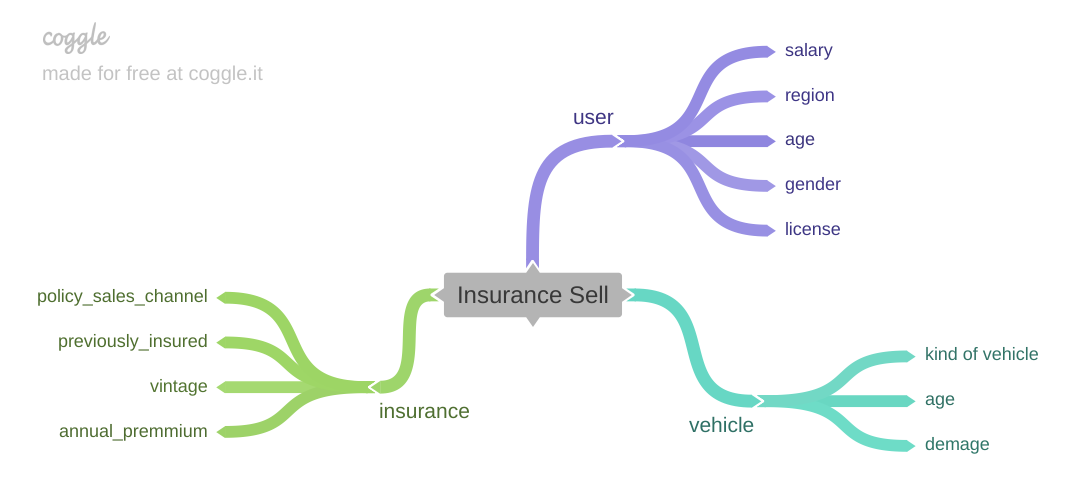

In [186]:
Image('../img/insurance_sell.png')

## 5.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

In [199]:
profile = ProfileReport(df05, title="Insurance Cross Sell", html={'style': {'full_width':True}}, minimal=True)

profile.to_file(output_file='insurance_cross_sell.html')

## 5.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

## 5.3 Multivariable analysis (Balanced Dataset)

In [208]:
num_attributes = df05.select_dtypes(include=['int64', 'float64'])
cat_attributes = df05.select_dtypes(exclude=['int64', 'float64'])

### 5.3.1 Numerical

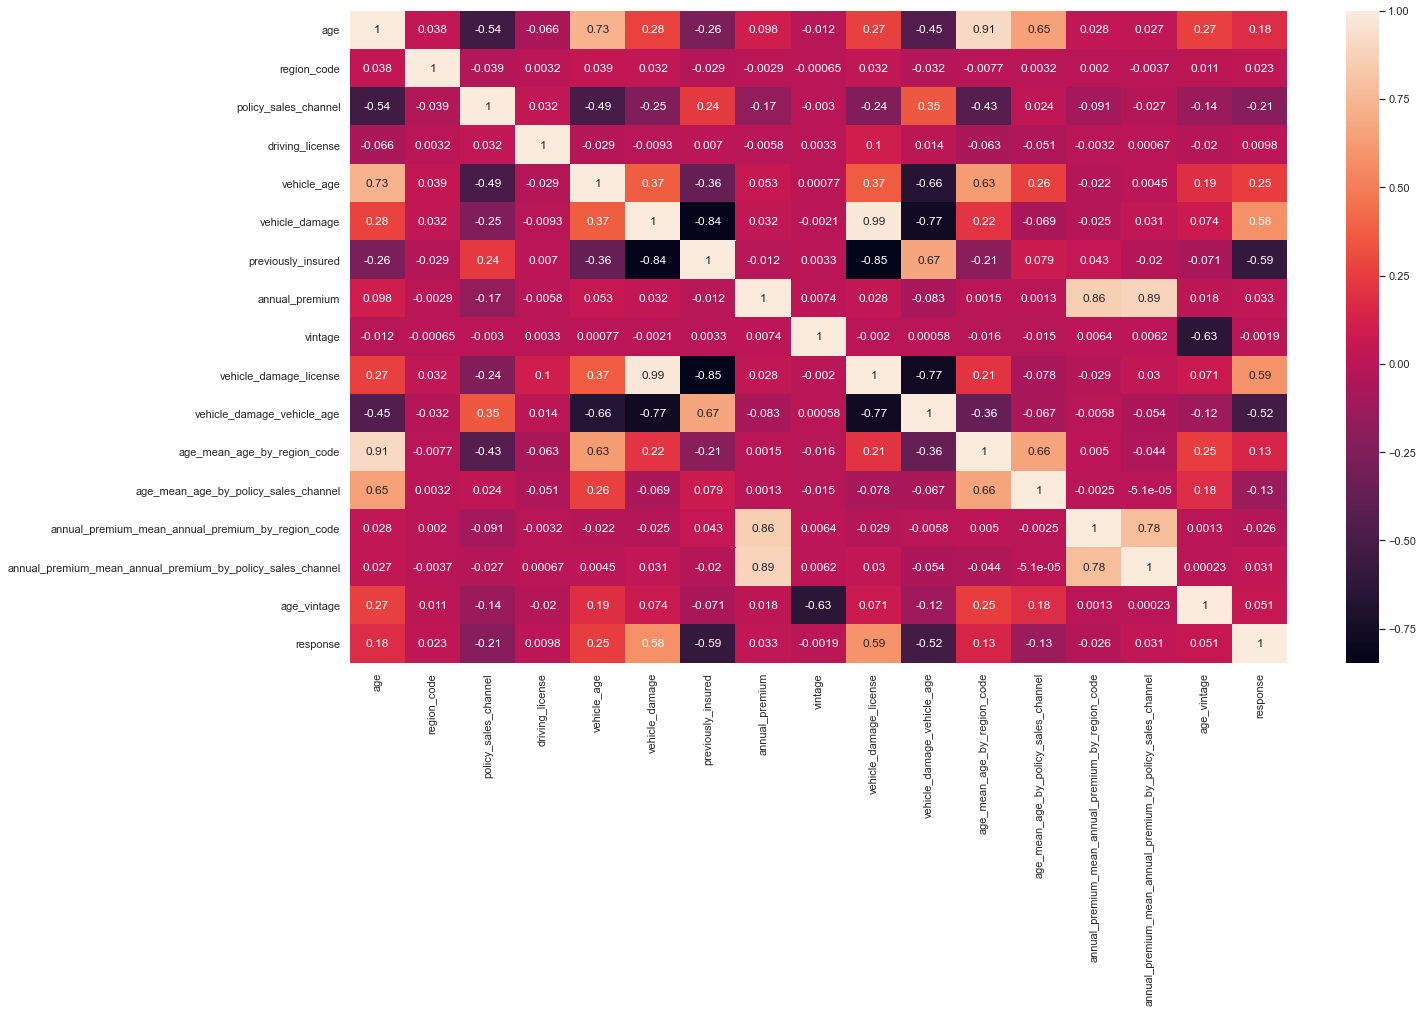

In [209]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(21,12))
sns.heatmap(correlation, annot=True);

### 5.3.2 Categorical

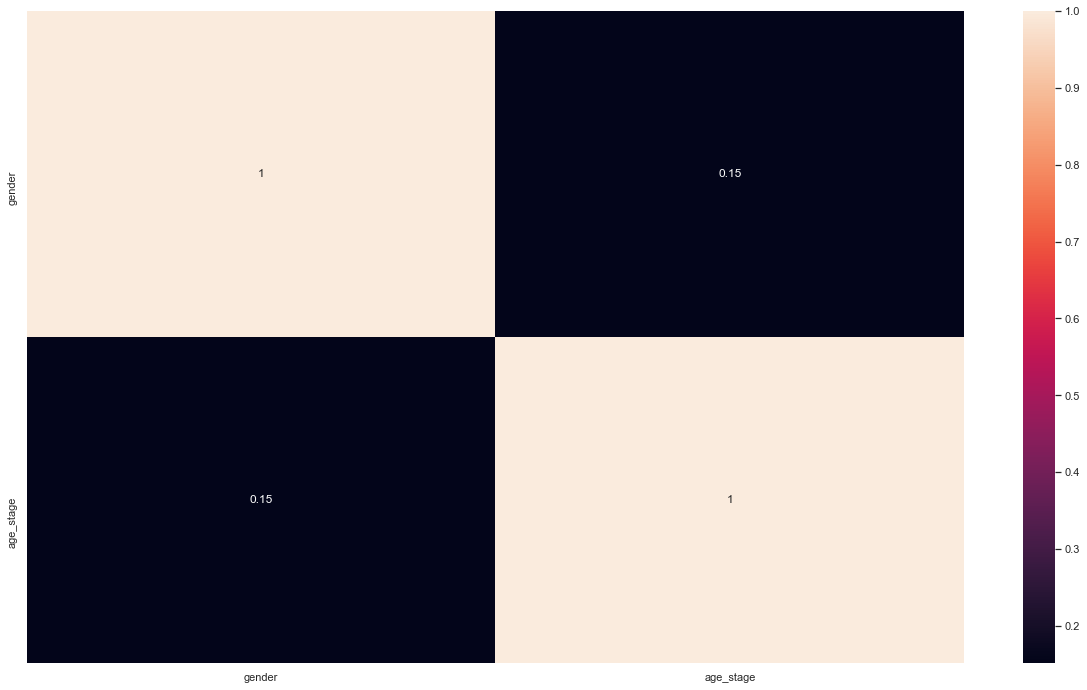

In [210]:
# list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes.columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append list
        corr_list.append(corr)
        
    # append correlation list for each ref attributes  
    corr_dict[ref] = corr_list
    
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
plt.figure(figsize=(15,12))
sns.heatmap(d, annot=True);

# 6.0 Data Filtering (Attributes with High Correlation)

In [187]:
# cols_drop = ['']
# df06 = df05.drop(cols_drop, axis=1)

df06 = df05.copy() ### will be changed

# 7.0 Data Preparation

In [188]:
# Numerical
num_attributes = df06.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df06.select_dtypes(exclude=['int64', 'float64'])

## 7.1 Rescaling

## 7.2 Encoding

In [189]:
# Dummy variable
df07_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df07 = pd.concat([num_attributes, df07_dummy], axis=1)

## 7.3 Transformation

# 8.0 Feature Selection

In [190]:
df08 = df07.copy()

## 8.1 Boruta as Feature Selector

In [200]:
X = df08.drop(columns=['response'], axis=1)
y = df08['response'].copy()


# Training and Validation dataset for Boruta
X_train_n = X.to_numpy()
y_train_n = y.values.ravel()

# define RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, verbose=1, n_estimators='auto', random_state=42)
boruta.fit(X_train_n, y_train_n)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	0
Rejected: 	11


BorutaPy(estimator=RandomForestClassifier(n_estimators=70, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x22AA1F28540),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x22AA1F28540, verbose=1)

In [201]:
cols_selected = boruta.support_.tolist()

# Best Features
X_train_fs = X
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

cols_not_select_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))
cols_selected_boruta

['age',
 'region_code',
 'policy_sales_channel',
 'vehicle_damage',
 'previously_insured',
 'annual_premium',
 'vintage',
 'vehicle_damage_license',
 'vehicle_damage_vehicle_age',
 'age_mean_age_by_region_code',
 'age_mean_age_by_policy_sales_channel',
 'annual_premium_mean_annual_premium_by_region_code',
 'annual_premium_mean_annual_premium_by_policy_sales_channel',
 'age_vintage']

## 8.? Split into Train and Validation

In [202]:
cols_selected = ['age',
                 'region_code',
                 'policy_sales_channel',
                 'vehicle_damage',
                 'previously_insured',
                 'annual_premium',
                 'vintage',
                 'vehicle_damage_license',
                 'vehicle_damage_vehicle_age',
                 'age_mean_age_by_region_code',
                 'age_mean_age_by_policy_sales_channel',
                 'annual_premium_mean_annual_premium_by_region_code',
                 'annual_premium_mean_annual_premium_by_policy_sales_channel',
                 'age_vintage']


X = df08[cols_selected]
y = df08['response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# 9.0 Machine Learning Model

## 9.1 Baseline model

### 9.1.1 Random Choices

In [203]:
response_list = y_train.drop_duplicates().sort_values().tolist()
response_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 9.1.2 Random Choices Performance

Accuracy: 0.5005517374891104
Balanced Accuracy: 0.5005100803999116
Kappa Score: 0.0010200893431197011
              precision    recall  f1-score   support

           0       0.51      0.50      0.51     52295
           1       0.49      0.50      0.50     51015

    accuracy                           0.50    103310
   macro avg       0.50      0.50      0.50    103310
weighted avg       0.50      0.50      0.50    103310



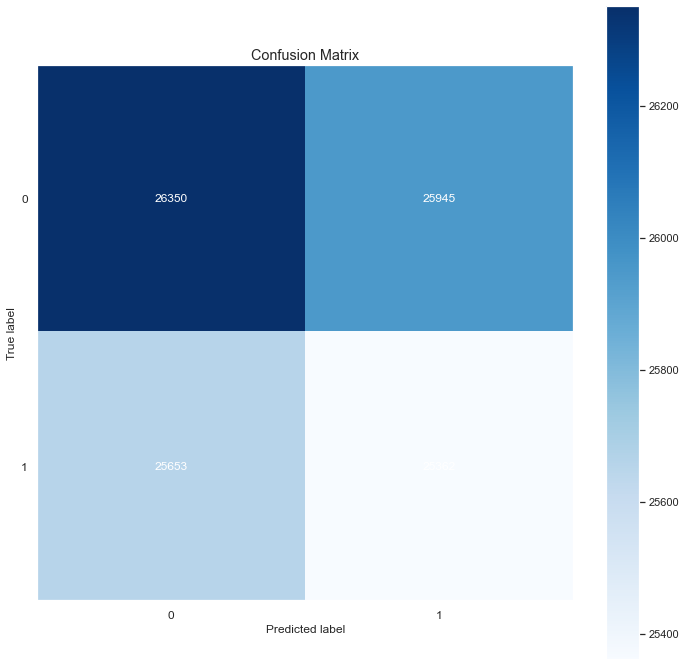

In [204]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 9.2 Machine Learning Model

### 9.2.1 Random Forest

In [205]:
# Model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

yhat_rf = rf.predict(X_test)

### 9.2.2 Random Forest Performance

Accuracy: 0.9128835543509825
Balanced Accuracy: 0.9129255949337916
Kappa Score: 0.8257596695414325
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     52295
           1       0.91      0.92      0.91     51015

    accuracy                           0.91    103310
   macro avg       0.91      0.91      0.91    103310
weighted avg       0.91      0.91      0.91    103310



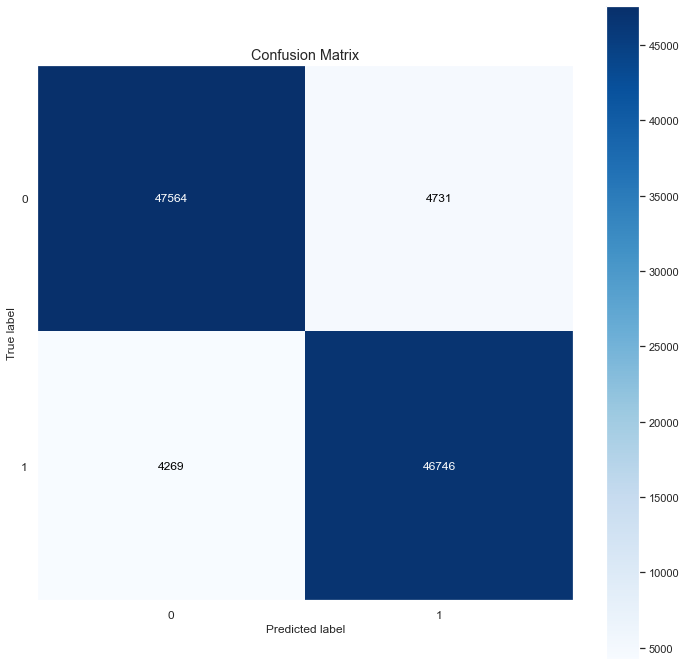

In [206]:
# Accuracy
acc_rf = accuracy_score(y_test, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_test, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_test, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_test, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_rf, normalize=False, figsize=(12, 12));

### 9.2.3 Random Forest Performance - Cross Validation

In [196]:
model = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
cross_validation(X_train, y_train, 'Random Forest', model, num_folds=5, verbose=True)

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


,Model Name,Precision CV,Recall CV,F1 Score CV,Kappa CV,Balanced Accuracy,Average Precision Score CV,ROC AUC CV
0,Random Forest,0.9053 +/- 0.0011,0.9166 +/- 0.0009,0.9109 +/- 0.0006,0.8228 +/- 0.0012,0.9115 +/- 0.0006,0.9801 +/- 0.0001,0.9782 +/- 0.0001
